# Catch Basin Classifier
An image classifier written in Python with Tensorflow. Classifies catch basins in 3 classes.

The three classes are:
* `blocked` 🠊 0
* `clear` 🠊 1
* `partial` 🠊 2

## Imports

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.losses import CategoricalCrossentropy
from PIL import Image
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

## Compute Average Image Size
The average image size is computed to ensure that all images are of the same width and height. This will be done by resizing all the images to the average dimension.

In [2]:
widths = []
heights = []

for path in glob('data/**/**/*.JPG'):
    with Image.open(path) as img:
        widths.append(img.width)
        heights.append(img.height)

In [138]:
image_size = round(sum(widths) / len(widths)), round(sum(heights) / len(heights))
image_size = (180, 180)

## Load and Prepare Data
Load the data and split into two groups: *training* and *validation*

In [174]:
training_dataset = tf.keras.utils.image_dataset_from_directory("augmented_data", image_size=image_size, batch_size=16)
validation_dataset = tf.keras.utils.image_dataset_from_directory("data/validation", image_size=image_size, batch_size=16)

# Get list of classnames to verify that the class names were interpreted correctly
print(training_dataset.class_names)
print(validation_dataset.class_names)

# training_datagen = ImageDataGenerator(rescale=1/255.0)
# training_generator = training_datagen.flow_from_directory(
#     'augmented_data',
#     classes=['blocked', 'clear', 'partial'],
#     batch_size=32,
#     class_mode='categorical',
#     target_size=image_size
# )

# validation_datagen = ImageDataGenerator(rescale=1/255.0)
# validation_generator = validation_datagen.flow_from_directory(
#     'validation_data',
#     classes=['blocked', 'clear', 'partial'],
#     batch_size=32,
#     class_mode='categorical',
#     target_size=image_size,
# )

Found 258 files belonging to 3 classes.
Found 50 files belonging to 3 classes.
['blocked', 'clear', 'partial']
['blocked', 'clear', 'partial']


In [175]:
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [176]:
for images, labels in training_dataset.take(4):
    print(images.shape)

(16, 180, 180, 3)
(2, 180, 180, 3)
(16, 180, 180, 3)
(16, 180, 180, 3)


## Construction of the Model
Contruct a convolutional neural network. A `Rescaling` Layer is added to normalize `RGB` values. 

In [202]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(*image_size, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_36 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 22, 22, 64)      

## Training
Begin training the model with `training_dataset` and `validation_dataset`

In [203]:
epochs = 35

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='max', factor=0.2, patience=3, min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/35
17/17 [==============================] - 4s 238ms/step - loss: 1.3935 - accuracy: 0.3566 - val_loss: 1.0995 - val_accuracy: 0.3600
Epoch 2/35
17/17 [==============================] - 4s 236ms/step - loss: 1.0986 - accuracy: 0.3295 - val_loss: 1.0990 - val_accuracy: 0.2200
Epoch 3/35
17/17 [==============================] - 4s 237ms/step - loss: 1.0988 - accuracy: 0.3527 - val_loss: 1.0990 - val_accuracy: 0.2400
Epoch 4/35
17/17 [==============================] - 4s 235ms/step - loss: 1.0991 - accuracy: 0.3178 - val_loss: 1.0975 - val_accuracy: 0.4200
Epoch 5/35
17/17 [==============================] - 4s 235ms/step - loss: 1.0991 - accuracy: 0.3178 - val_loss: 1.0976 - val_accuracy: 0.4200
Epoch 6/35
17/17 [==============================] - 4s 236ms/step - loss: 1.0987 - accuracy: 0.3256 - val_loss: 1.0972 - val_accuracy: 0.4200
Epoch 7/35
17/17 [==============================] - 4s 256ms/step - loss: 1.0988 - accuracy: 0.3256 - val_loss: 1.0971 - val_accuracy: 0.4200
Epoch 

## Training Analysis
See how the model did. 

Collect metrics.

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Graph the metrics

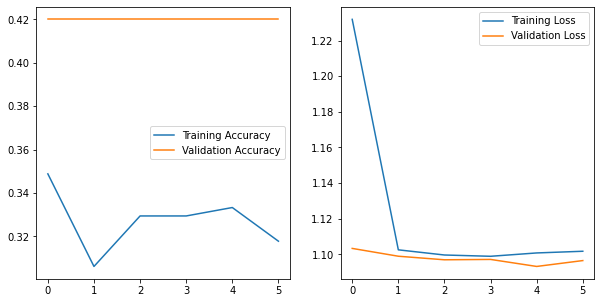

In [193]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

Print out metrics such as accuracy and loss.

In [95]:
print('accuracy:', acc[-1], 'val_accuracy:', val_acc[-1])
print('loss', loss[-1], 'val_loss:', val_loss[-1])

accuracy: 0.3450980484485626 val_accuracy: 0.30000001192092896
loss 1.0941025018692017 val_loss: 1.0975168943405151


In [98]:
img = load_img('validation_images/GSV_Lents/10_Blocked.JPG', target_size=image_size)
img_arr = img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.
pred = model.predict(img_arr)
print(pred)
np.argmax(tf.nn.softmax(pred))

[[ 0.03794     0.10003931 -0.0187835 ]]


1

## Save the Model
Save the model so that it can be loaded again for future use.

In [31]:
saved_models = pathlib.Path.cwd() / 'saved_models'
if not saved_models.exists():
    saved_models.mkdir()


model_dirs = list(saved_models.iterdir())
if len(model_dirs) == 0: 
    model.save(saved_models / 'model-0')
else:
    num_strs = map(lambda x: x[len("model-")], saved_models.iterdir())
    num = max(list(map(lambda x: int(x), num_strs))) + 1
    model.save(saved_models / f'model-{num}')

INFO:tensorflow:Assets written to: C:\Users\SA\Desktop\Programming\projects\catch_basin_classifier\saved_models\model-0\assets
